<a href="https://colab.research.google.com/github/tomoakism/geoguessrpd/blob/main/Geoguessr_pd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Google Driveをマウント

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

In [ ]:
%cd "/content/drive/My Drive/Geoguessrpd"

GPUに接続

In [ ]:
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)



---



データセットを読み込むためのクラス


In [ ]:
from torch.utils.data import Dataset
from PIL import Image
import os

class StreetViewDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_filenames = os.listdir(image_dir)
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.image_filenames[idx])
        image = Image.open(img_name).convert('RGB')

        # ファイル名から座標を取り出す
        coord = self.image_filenames[idx].split('_')[:2]
        coord = [float(x) for x in coord]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(coord)

読み込んだ画像の処理

In [ ]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

データセットを分割

In [ ]:
from torch.utils.data import random_split

dataset = StreetViewDataset("./images", transform=transform)

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

データセットの読み込み

In [ ]:
from torch.utils.data import DataLoader

batch_num = 256

train_loader = DataLoader(train_dataset, batch_size=batch_num, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_num, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_num, shuffle=True)

学習済みResNet-50モデルの作成

In [ ]:
from torchvision import models

model = models.resnet50(pretrained=True)

# 事前学習済みのレイヤーを固定
for param in model.parameters():
    param.requires_grad = False

# 最終レイヤーを変更
model.fc = torch.nn.Linear(model.fc.in_features, 2)

model = model.to(device)

ファインチューニング

In [ ]:
import torch.optim as optim

criterion = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters())

train_losses = []
val_losses = []



---

学習済みモデルを読み込む


In [ ]:
# Assuming you have a model and optimizer created already
checkpoint = torch.load('model_256.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])


In [ ]:
import pickle

train_losses = []
val_losses = []

f = open('./train_loss_list.txt','rb')
train_losses = pickle.load(f)

f = open('./val_loss_list.txt','rb')
val_losses = pickle.load(f)



---



In [ ]:
num_epochs = 10

In [ ]:
for epoch in range(num_epochs):
    train_loss = 0.0
    val_loss = 0.0

    model.train()
    for inputs, labels in train_loader:
      inputs, labels = inputs.to(device), labels.to(device)

      optimizer.zero_grad()

      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      train_loss += loss.item()

    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    train_loss = train_loss / len(train_loader)
    val_loss = val_loss / len(val_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Validation Loss: {val_loss}')

ロスをプロット

In [ ]:
print(f"Training losses: {train_losses}")
print(f"Validation losses: {val_losses}")
print(len(train_losses))

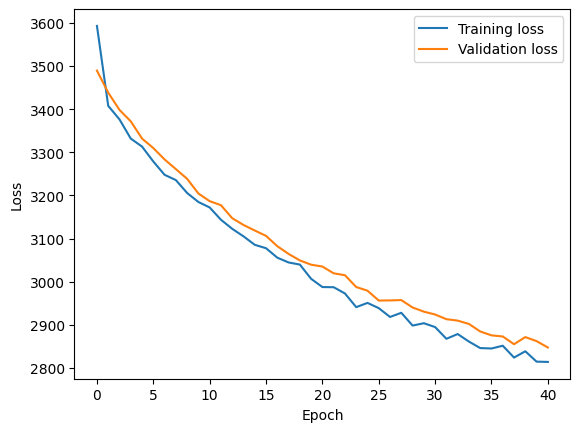

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

モデルをセーブ

In [ ]:
checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
}
torch.save(checkpoint, '20230616_256.pth')


In [ ]:
import pickle
f = open('./train_loss_list.txt', 'wb')
list_row = train_losses
pickle.dump(list_row, f)

f = open('./val_loss_list.txt', 'wb')
list_row = val_losses
pickle.dump(list_row, f)


モデルのテスト

モデルをチェックポイントからロード

In [ ]:
checkpoint = torch.load('model_256.pth')
model.load_state_dict(checkpoint['model_state_dict'])

In [ ]:
model = model.to(device)
model.eval()

total_loss = 0

# テストデータを学習済みモデルでテスト
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        total_loss += loss.item() * inputs.size(0)

avg_loss = total_loss / len(test_loader.dataset)

print('Test Loss:', avg_loss)